In [0]:
#please ignore this cell when grading

from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/LIP Labs/hw 03/

import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/LIP Labs/hw 03/')

In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [0]:
!pip install pyquery

In [0]:
from urllib.parse import urljoin
from pyquery import PyQuery
import os
import requests
import csv
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Getting the url to download data and make two seperate variables for images and descriptions**

In [0]:
pascal_url = 'http://vision.cs.uiuc.edu/pascal-sentences/'
dataset_directory = 'dataset/'
sentence_directory = 'sentence/'
dom = PyQuery(pascal_url)

**Downloading all the images**

For this part of the solution, I have downloaded all the images and descriptions to my Google Drive, since I am running this notebook on Colab, I used my Google Drive as the hard disk. Anyway this code is working for local hard disks too. In case it gives any error, please create 'dataset' and 'sentence' folders and execute the code again. It will surely work.

In [0]:
for img in dom('img').items():
  img_src = img.attr['src']
  category, img_file_name = os.path.split(img_src)

  #make category directories
  output_dir = dataset_directory + category
  if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

  #download image
  output = os.path.join(output_dir, img_file_name)
  print(output)
  if img_src.startswith('http'):
    img_url = img_src
  else:
    img_url = urljoin(pascal_url, img_src)
  if os.path.isfile(output):
    print("Already downloaded, Skipping: ", output)
    continue
  print("Downloading: ", output)
  with open(output,'wb') as f:
    
    while True:
      result = requests.get(img_url)
      raw = result.content
      if result.status_code == 200:
        f.write(raw)
        break
      print("error occurred while fetching img")
      print("retry...")

**Downloading all the descriptions**

In [0]:
#tbody disappears in pyquery DOM
for tr in dom('body>table>tr').items():
  img_src = tr('img').attr['src']
  category, img_file_name = os.path.split(img_src)

  #make category directories
  output_dir = sentence_directory + category
  if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

  #dowonload sentences
  head, tail = os.path.splitext(img_file_name)
  sentence_file_name = head + ".txt"
  output = os.path.join(output_dir, sentence_file_name)
  if os.path.isfile(output):
    print("Already downloaded, Skipping: ", output)
    continue
  print("Downloading: ", output)
  with open(output,'w') as f:
    for td in tr('table tr td').items():
      f.write(td.text() + "\n")

**Images directory list**

Get the directory list to a variable so I can use it in future to read all the images and documents from hard disk to numpy.

In [7]:
directory_list = os.listdir('dataset')
directory_list

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [0]:
images_list = []
for directory in directory_list:
  
  #cd to the the directory
  path = dataset_directory + directory
  
  #gets all the files ending with jpg
  images_list += [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]

**Reading all the images from the disk to an array**

using mpimg to handle numpy image manipulations, so i dont have to grayscale the image or use rgb conversions when viewing or drawing keypoints.

In [0]:
images_array_list = [(mpimg.imread(im,0)) for im in images_list]

**Sample image from the array**

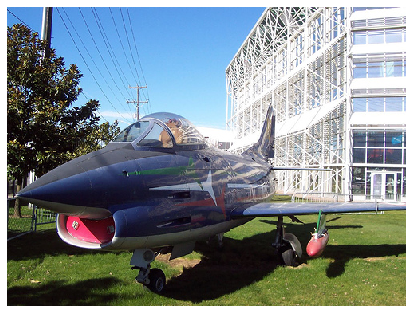

In [10]:
plt.imshow(images_array_list[4])
plt.xticks([]), plt.yticks([])
plt.show()

**Read all the descriptions from the disk to an array**

In [0]:
description_list = []
for directory in directory_list:
  
  #into the directory
  path = sentence_directory + directory
  
  #gets all the files ending with txt
  description_list += [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.txt')]

In [0]:
#read all the files we got above
descriptions_bodies = [(open(im, 'r').read()) for im in description_list]

**Sample description**

In [13]:
print(descriptions_bodies[4])

A blue grounded fighter jet is parked on grass in front of a glass building.
A blue jet stopped on a lawn.
A fighter jet sits on display.
A jet plane on exhibit in front of a modern building.
Blue fighter jet parked in the green grass.



**Bag Of Visual Words**

In [0]:
#defining feature extractor
extractor = cv2.xfeatures2d.SIFT_create()

**Extracting keypoints and descriptors from image**

In [0]:
keypoints_list = []
descriptor_list = []

for image in images_array_list:
  
  #extract keypoints and descriptors and doing it for all the images in the array
  keypoints, descriptor = extractor.detectAndCompute(image, None)
  
  #append extracted data to seperate arrays
  keypoints_list.append(keypoints)
  descriptor_list.append(descriptor)

**Collect all the descriptors**

In [31]:
#concat all the descriptors of all the images to a single array
descriptors_of_all_images = np.concatenate(descriptor_list, axis=0)

#shape
descriptors_of_all_images.shape

(854044, 128)

**KMeans Clusters**

k-means algorithm searches for a pre-determined number of clusters within our 2d dataset, here actualy its a mini batch cluster. containing 1000 distinct blobs.

In [34]:
#creating a mini cluster with 1000 bases
kmeans = MiniBatchKMeans(n_clusters = 1000)

#fit the descriptors to clusters
kmeans.fit(descriptors_of_all_images)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=1000, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

**Histograms**

In [0]:
preprocessed_image = []

for descriptor in descriptor_list:
  
  if (descriptor is not None):
    
    histogram = np.zeros(len(kmeans.cluster_centers_))
    
    cluster_result =  kmeans.predict(descriptor)
    
    for i in cluster_result:
        histogram[i] += 1.0
        
    preprocessed_image.append(histogram)

**tf-idf scheme**

In [0]:
#getting all the documents list to a single variable for future use
documents = [descriptions_bodies[0],descriptions_bodies[1],descriptions_bodies[2],descriptions_bodies[3],descriptions_bodies[4],descriptions_bodies[5],descriptions_bodies[6],descriptions_bodies[7],descriptions_bodies[8],descriptions_bodies[9],descriptions_bodies[10],descriptions_bodies[11],descriptions_bodies[12],descriptions_bodies[13],descriptions_bodies[14],descriptions_bodies[15],descriptions_bodies[16],descriptions_bodies[17],descriptions_bodies[18],descriptions_bodies[19],descriptions_bodies[20],descriptions_bodies[21],descriptions_bodies[22],descriptions_bodies[23],descriptions_bodies[24],descriptions_bodies[25],descriptions_bodies[26],descriptions_bodies[27],descriptions_bodies[28],descriptions_bodies[29],descriptions_bodies[30],descriptions_bodies[31],descriptions_bodies[32],descriptions_bodies[33],descriptions_bodies[34],descriptions_bodies[35],descriptions_bodies[36],descriptions_bodies[37],descriptions_bodies[38],descriptions_bodies[39],descriptions_bodies[40],descriptions_bodies[41],descriptions_bodies[42],descriptions_bodies[43],descriptions_bodies[44],descriptions_bodies[45],descriptions_bodies[46],descriptions_bodies[47],descriptions_bodies[48],descriptions_bodies[49],descriptions_bodies[50],descriptions_bodies[51],descriptions_bodies[52],descriptions_bodies[53],descriptions_bodies[54],descriptions_bodies[55],descriptions_bodies[56],descriptions_bodies[57],descriptions_bodies[58],descriptions_bodies[59],descriptions_bodies[60],descriptions_bodies[61],descriptions_bodies[62],descriptions_bodies[63],descriptions_bodies[64],descriptions_bodies[65],descriptions_bodies[66],descriptions_bodies[67],descriptions_bodies[68],descriptions_bodies[69],descriptions_bodies[70],descriptions_bodies[71],descriptions_bodies[72],descriptions_bodies[73],descriptions_bodies[74],descriptions_bodies[75],descriptions_bodies[76],descriptions_bodies[77],descriptions_bodies[78],descriptions_bodies[79],descriptions_bodies[80],descriptions_bodies[81],descriptions_bodies[82],descriptions_bodies[83],descriptions_bodies[84],descriptions_bodies[85],descriptions_bodies[86],descriptions_bodies[87],descriptions_bodies[88],descriptions_bodies[89],descriptions_bodies[90],descriptions_bodies[91],descriptions_bodies[92],descriptions_bodies[93],descriptions_bodies[94],descriptions_bodies[95],descriptions_bodies[96],descriptions_bodies[97],descriptions_bodies[98],descriptions_bodies[99],descriptions_bodies[100],descriptions_bodies[101],descriptions_bodies[102],descriptions_bodies[103],descriptions_bodies[104],descriptions_bodies[105],descriptions_bodies[106],descriptions_bodies[107],descriptions_bodies[108],descriptions_bodies[109],descriptions_bodies[110],descriptions_bodies[111],descriptions_bodies[112],descriptions_bodies[113],descriptions_bodies[114],descriptions_bodies[115],descriptions_bodies[116],descriptions_bodies[117],descriptions_bodies[118],descriptions_bodies[119],descriptions_bodies[120],descriptions_bodies[121],descriptions_bodies[122],descriptions_bodies[123],descriptions_bodies[124],descriptions_bodies[125],descriptions_bodies[126],descriptions_bodies[127],descriptions_bodies[128],descriptions_bodies[129],descriptions_bodies[130],descriptions_bodies[131],descriptions_bodies[132],descriptions_bodies[133],descriptions_bodies[134],descriptions_bodies[135],descriptions_bodies[136],descriptions_bodies[137],descriptions_bodies[138],descriptions_bodies[139],descriptions_bodies[140],descriptions_bodies[141],descriptions_bodies[142],descriptions_bodies[143],descriptions_bodies[144],descriptions_bodies[145],descriptions_bodies[146],descriptions_bodies[147],descriptions_bodies[148],descriptions_bodies[149],descriptions_bodies[150],descriptions_bodies[151],descriptions_bodies[152],descriptions_bodies[153],descriptions_bodies[154],descriptions_bodies[155],descriptions_bodies[156],descriptions_bodies[157],descriptions_bodies[158],descriptions_bodies[159],descriptions_bodies[160],descriptions_bodies[161],descriptions_bodies[162],descriptions_bodies[163],descriptions_bodies[164],descriptions_bodies[165],descriptions_bodies[166],descriptions_bodies[167],descriptions_bodies[168],descriptions_bodies[169],descriptions_bodies[170],descriptions_bodies[171],descriptions_bodies[172],descriptions_bodies[173],descriptions_bodies[174],descriptions_bodies[175],descriptions_bodies[176],descriptions_bodies[177],descriptions_bodies[178],descriptions_bodies[179],descriptions_bodies[180],descriptions_bodies[181],descriptions_bodies[182],descriptions_bodies[183],descriptions_bodies[184],descriptions_bodies[185],descriptions_bodies[186],descriptions_bodies[187],descriptions_bodies[188],descriptions_bodies[189],descriptions_bodies[190],descriptions_bodies[191],descriptions_bodies[192],descriptions_bodies[193],descriptions_bodies[194],descriptions_bodies[195],descriptions_bodies[196],descriptions_bodies[197],descriptions_bodies[198],descriptions_bodies[199],descriptions_bodies[200],descriptions_bodies[201],descriptions_bodies[202],descriptions_bodies[203],descriptions_bodies[204],descriptions_bodies[205],descriptions_bodies[206],descriptions_bodies[207],descriptions_bodies[208],descriptions_bodies[209],descriptions_bodies[210],descriptions_bodies[211],descriptions_bodies[212],descriptions_bodies[213],descriptions_bodies[214],descriptions_bodies[215],descriptions_bodies[216],descriptions_bodies[217],descriptions_bodies[218],descriptions_bodies[219],descriptions_bodies[220],descriptions_bodies[221],descriptions_bodies[222],descriptions_bodies[223],descriptions_bodies[224],descriptions_bodies[225],descriptions_bodies[226],descriptions_bodies[227],descriptions_bodies[228],descriptions_bodies[229],descriptions_bodies[230],descriptions_bodies[231],descriptions_bodies[232],descriptions_bodies[233],descriptions_bodies[234],descriptions_bodies[235],descriptions_bodies[236],descriptions_bodies[237],descriptions_bodies[238],descriptions_bodies[239],descriptions_bodies[240],descriptions_bodies[241],descriptions_bodies[242],descriptions_bodies[243],descriptions_bodies[244],descriptions_bodies[245],descriptions_bodies[246],descriptions_bodies[247],descriptions_bodies[248],descriptions_bodies[249],descriptions_bodies[250],descriptions_bodies[251],descriptions_bodies[252],descriptions_bodies[253],descriptions_bodies[254],descriptions_bodies[255],descriptions_bodies[256],descriptions_bodies[257],descriptions_bodies[258],descriptions_bodies[259],descriptions_bodies[260],descriptions_bodies[261],descriptions_bodies[262],descriptions_bodies[263],descriptions_bodies[264],descriptions_bodies[265],descriptions_bodies[266],descriptions_bodies[267],descriptions_bodies[268],descriptions_bodies[269],descriptions_bodies[270],descriptions_bodies[271],descriptions_bodies[272],descriptions_bodies[273],descriptions_bodies[274],descriptions_bodies[275],descriptions_bodies[276],descriptions_bodies[277],descriptions_bodies[278],descriptions_bodies[279],descriptions_bodies[280],descriptions_bodies[281],descriptions_bodies[282],descriptions_bodies[283],descriptions_bodies[284],descriptions_bodies[285],descriptions_bodies[286],descriptions_bodies[287],descriptions_bodies[288],descriptions_bodies[289],descriptions_bodies[290],descriptions_bodies[291],descriptions_bodies[292],descriptions_bodies[293],descriptions_bodies[294],descriptions_bodies[295],descriptions_bodies[296],descriptions_bodies[297],descriptions_bodies[298],descriptions_bodies[299],descriptions_bodies[300],descriptions_bodies[301],descriptions_bodies[302],descriptions_bodies[303],descriptions_bodies[304],descriptions_bodies[305],descriptions_bodies[306],descriptions_bodies[307],descriptions_bodies[308],descriptions_bodies[309],descriptions_bodies[310],descriptions_bodies[311],descriptions_bodies[312],descriptions_bodies[313],descriptions_bodies[314],descriptions_bodies[315],descriptions_bodies[316],descriptions_bodies[317],descriptions_bodies[318],descriptions_bodies[319],descriptions_bodies[320],descriptions_bodies[321],descriptions_bodies[322],descriptions_bodies[323],descriptions_bodies[324],descriptions_bodies[325],descriptions_bodies[326],descriptions_bodies[327],descriptions_bodies[328],descriptions_bodies[329],descriptions_bodies[330],descriptions_bodies[331],descriptions_bodies[332],descriptions_bodies[333],descriptions_bodies[334],descriptions_bodies[335],descriptions_bodies[336],descriptions_bodies[337],descriptions_bodies[338],descriptions_bodies[339],descriptions_bodies[340],descriptions_bodies[341],descriptions_bodies[342],descriptions_bodies[343],descriptions_bodies[344],descriptions_bodies[345],descriptions_bodies[346],descriptions_bodies[347],descriptions_bodies[348],descriptions_bodies[349],descriptions_bodies[350],descriptions_bodies[351],descriptions_bodies[352],descriptions_bodies[353],descriptions_bodies[354],descriptions_bodies[355],descriptions_bodies[356],descriptions_bodies[357],descriptions_bodies[358],descriptions_bodies[359],descriptions_bodies[360],descriptions_bodies[361],descriptions_bodies[362],descriptions_bodies[363],descriptions_bodies[364],descriptions_bodies[365],descriptions_bodies[366],descriptions_bodies[367],descriptions_bodies[368],descriptions_bodies[369],descriptions_bodies[370],descriptions_bodies[371],descriptions_bodies[372],descriptions_bodies[373],descriptions_bodies[374],descriptions_bodies[375],descriptions_bodies[376],descriptions_bodies[377],descriptions_bodies[378],descriptions_bodies[379],descriptions_bodies[380],descriptions_bodies[381],descriptions_bodies[382],descriptions_bodies[383],descriptions_bodies[384],descriptions_bodies[385],descriptions_bodies[386],descriptions_bodies[387],descriptions_bodies[388],descriptions_bodies[389],descriptions_bodies[390],descriptions_bodies[391],descriptions_bodies[392],descriptions_bodies[393],descriptions_bodies[394],descriptions_bodies[395],descriptions_bodies[396],descriptions_bodies[397],descriptions_bodies[398],descriptions_bodies[399],descriptions_bodies[400],descriptions_bodies[401],descriptions_bodies[402],descriptions_bodies[403],descriptions_bodies[404],descriptions_bodies[405],descriptions_bodies[406],descriptions_bodies[407],descriptions_bodies[408],descriptions_bodies[409],descriptions_bodies[410],descriptions_bodies[411],descriptions_bodies[412],descriptions_bodies[413],descriptions_bodies[414],descriptions_bodies[415],descriptions_bodies[416],descriptions_bodies[417],descriptions_bodies[418],descriptions_bodies[419],descriptions_bodies[420],descriptions_bodies[421],descriptions_bodies[422],descriptions_bodies[423],descriptions_bodies[424],descriptions_bodies[425],descriptions_bodies[426],descriptions_bodies[427],descriptions_bodies[428],descriptions_bodies[429],descriptions_bodies[430],descriptions_bodies[431],descriptions_bodies[432],descriptions_bodies[433],descriptions_bodies[434],descriptions_bodies[435],descriptions_bodies[436],descriptions_bodies[437],descriptions_bodies[438],descriptions_bodies[439],descriptions_bodies[440],descriptions_bodies[441],descriptions_bodies[442],descriptions_bodies[443],descriptions_bodies[444],descriptions_bodies[445],descriptions_bodies[446],descriptions_bodies[447],descriptions_bodies[448],descriptions_bodies[449],descriptions_bodies[450],descriptions_bodies[451],descriptions_bodies[452],descriptions_bodies[453],descriptions_bodies[454],descriptions_bodies[455],descriptions_bodies[456],descriptions_bodies[457],descriptions_bodies[458],descriptions_bodies[459],descriptions_bodies[460],descriptions_bodies[461],descriptions_bodies[462],descriptions_bodies[463],descriptions_bodies[464],descriptions_bodies[465],descriptions_bodies[466],descriptions_bodies[467],descriptions_bodies[468],descriptions_bodies[469],descriptions_bodies[470],descriptions_bodies[471],descriptions_bodies[472],descriptions_bodies[473],descriptions_bodies[474],descriptions_bodies[475],descriptions_bodies[476],descriptions_bodies[477],descriptions_bodies[478],descriptions_bodies[479],descriptions_bodies[480],descriptions_bodies[481],descriptions_bodies[482],descriptions_bodies[483],descriptions_bodies[484],descriptions_bodies[485],descriptions_bodies[486],descriptions_bodies[487],descriptions_bodies[488],descriptions_bodies[489],descriptions_bodies[490],descriptions_bodies[491],descriptions_bodies[492],descriptions_bodies[493],descriptions_bodies[494],descriptions_bodies[495],descriptions_bodies[496],descriptions_bodies[497],descriptions_bodies[498],descriptions_bodies[499],descriptions_bodies[500],descriptions_bodies[501],descriptions_bodies[502],descriptions_bodies[503],descriptions_bodies[504],descriptions_bodies[505],descriptions_bodies[506],descriptions_bodies[507],descriptions_bodies[508],descriptions_bodies[509],descriptions_bodies[510],descriptions_bodies[511],descriptions_bodies[512],descriptions_bodies[513],descriptions_bodies[514],descriptions_bodies[515],descriptions_bodies[516],descriptions_bodies[517],descriptions_bodies[518],descriptions_bodies[519],descriptions_bodies[520],descriptions_bodies[521],descriptions_bodies[522],descriptions_bodies[523],descriptions_bodies[524],descriptions_bodies[525],descriptions_bodies[526],descriptions_bodies[527],descriptions_bodies[528],descriptions_bodies[529],descriptions_bodies[530],descriptions_bodies[531],descriptions_bodies[532],descriptions_bodies[533],descriptions_bodies[534],descriptions_bodies[535],descriptions_bodies[536],descriptions_bodies[537],descriptions_bodies[538],descriptions_bodies[539],descriptions_bodies[540],descriptions_bodies[541],descriptions_bodies[542],descriptions_bodies[543],descriptions_bodies[544],descriptions_bodies[545],descriptions_bodies[546],descriptions_bodies[547],descriptions_bodies[548],descriptions_bodies[549],descriptions_bodies[550],descriptions_bodies[551],descriptions_bodies[552],descriptions_bodies[553],descriptions_bodies[554],descriptions_bodies[555],descriptions_bodies[556],descriptions_bodies[557],descriptions_bodies[558],descriptions_bodies[559],descriptions_bodies[560],descriptions_bodies[561],descriptions_bodies[562],descriptions_bodies[563],descriptions_bodies[564],descriptions_bodies[565],descriptions_bodies[566],descriptions_bodies[567],descriptions_bodies[568],descriptions_bodies[569],descriptions_bodies[570],descriptions_bodies[571],descriptions_bodies[572],descriptions_bodies[573],descriptions_bodies[574],descriptions_bodies[575],descriptions_bodies[576],descriptions_bodies[577],descriptions_bodies[578],descriptions_bodies[579],descriptions_bodies[580],descriptions_bodies[581],descriptions_bodies[582],descriptions_bodies[583],descriptions_bodies[584],descriptions_bodies[585],descriptions_bodies[586],descriptions_bodies[587],descriptions_bodies[588],descriptions_bodies[589],descriptions_bodies[590],descriptions_bodies[591],descriptions_bodies[592],descriptions_bodies[593],descriptions_bodies[594],descriptions_bodies[595],descriptions_bodies[596],descriptions_bodies[597],descriptions_bodies[598],descriptions_bodies[599],descriptions_bodies[600],descriptions_bodies[601],descriptions_bodies[602],descriptions_bodies[603],descriptions_bodies[604],descriptions_bodies[605],descriptions_bodies[606],descriptions_bodies[607],descriptions_bodies[608],descriptions_bodies[609],descriptions_bodies[610],descriptions_bodies[611],descriptions_bodies[612],descriptions_bodies[613],descriptions_bodies[614],descriptions_bodies[615],descriptions_bodies[616],descriptions_bodies[617],descriptions_bodies[618],descriptions_bodies[619],descriptions_bodies[620],descriptions_bodies[621],descriptions_bodies[622],descriptions_bodies[623],descriptions_bodies[624],descriptions_bodies[625],descriptions_bodies[626],descriptions_bodies[627],descriptions_bodies[628],descriptions_bodies[629],descriptions_bodies[630],descriptions_bodies[631],descriptions_bodies[632],descriptions_bodies[633],descriptions_bodies[634],descriptions_bodies[635],descriptions_bodies[636],descriptions_bodies[637],descriptions_bodies[638],descriptions_bodies[639],descriptions_bodies[640],descriptions_bodies[641],descriptions_bodies[642],descriptions_bodies[643],descriptions_bodies[644],descriptions_bodies[645],descriptions_bodies[646],descriptions_bodies[647],descriptions_bodies[648],descriptions_bodies[649],descriptions_bodies[650],descriptions_bodies[651],descriptions_bodies[652],descriptions_bodies[653],descriptions_bodies[654],descriptions_bodies[655],descriptions_bodies[656],descriptions_bodies[657],descriptions_bodies[658],descriptions_bodies[659],descriptions_bodies[660],descriptions_bodies[661],descriptions_bodies[662],descriptions_bodies[663],descriptions_bodies[664],descriptions_bodies[665],descriptions_bodies[666],descriptions_bodies[667],descriptions_bodies[668],descriptions_bodies[669],descriptions_bodies[670],descriptions_bodies[671],descriptions_bodies[672],descriptions_bodies[673],descriptions_bodies[674],descriptions_bodies[675],descriptions_bodies[676],descriptions_bodies[677],descriptions_bodies[678],descriptions_bodies[679],descriptions_bodies[680],descriptions_bodies[681],descriptions_bodies[682],descriptions_bodies[683],descriptions_bodies[684],descriptions_bodies[685],descriptions_bodies[686],descriptions_bodies[687],descriptions_bodies[688],descriptions_bodies[689],descriptions_bodies[690],descriptions_bodies[691],descriptions_bodies[692],descriptions_bodies[693],descriptions_bodies[694],descriptions_bodies[695],descriptions_bodies[696],descriptions_bodies[697],descriptions_bodies[698],descriptions_bodies[699],descriptions_bodies[700],descriptions_bodies[701],descriptions_bodies[702],descriptions_bodies[703],descriptions_bodies[704],descriptions_bodies[705],descriptions_bodies[706],descriptions_bodies[707],descriptions_bodies[708],descriptions_bodies[709],descriptions_bodies[710],descriptions_bodies[711],descriptions_bodies[712],descriptions_bodies[713],descriptions_bodies[714],descriptions_bodies[715],descriptions_bodies[716],descriptions_bodies[717],descriptions_bodies[718],descriptions_bodies[719],descriptions_bodies[720],descriptions_bodies[721],descriptions_bodies[722],descriptions_bodies[723],descriptions_bodies[724],descriptions_bodies[725],descriptions_bodies[726],descriptions_bodies[727],descriptions_bodies[728],descriptions_bodies[729],descriptions_bodies[730],descriptions_bodies[731],descriptions_bodies[732],descriptions_bodies[733],descriptions_bodies[734],descriptions_bodies[735],descriptions_bodies[736],descriptions_bodies[737],descriptions_bodies[738],descriptions_bodies[739],descriptions_bodies[740],descriptions_bodies[741],descriptions_bodies[742],descriptions_bodies[743],descriptions_bodies[744],descriptions_bodies[745],descriptions_bodies[746],descriptions_bodies[747],descriptions_bodies[748],descriptions_bodies[749],descriptions_bodies[750],descriptions_bodies[751],descriptions_bodies[752],descriptions_bodies[753],descriptions_bodies[754],descriptions_bodies[755],descriptions_bodies[756],descriptions_bodies[757],descriptions_bodies[758],descriptions_bodies[759],descriptions_bodies[760],descriptions_bodies[761],descriptions_bodies[762],descriptions_bodies[763],descriptions_bodies[764],descriptions_bodies[765],descriptions_bodies[766],descriptions_bodies[767],descriptions_bodies[768],descriptions_bodies[769],descriptions_bodies[770],descriptions_bodies[771],descriptions_bodies[772],descriptions_bodies[773],descriptions_bodies[774],descriptions_bodies[775],descriptions_bodies[776],descriptions_bodies[777],descriptions_bodies[778],descriptions_bodies[779],descriptions_bodies[780],descriptions_bodies[781],descriptions_bodies[782],descriptions_bodies[783],descriptions_bodies[784],descriptions_bodies[785],descriptions_bodies[786],descriptions_bodies[787],descriptions_bodies[788],descriptions_bodies[789],descriptions_bodies[790],descriptions_bodies[791],descriptions_bodies[792],descriptions_bodies[793],descriptions_bodies[794],descriptions_bodies[795],descriptions_bodies[796],descriptions_bodies[797],descriptions_bodies[798],descriptions_bodies[799],descriptions_bodies[800],descriptions_bodies[801],descriptions_bodies[802],descriptions_bodies[803],descriptions_bodies[804],descriptions_bodies[805],descriptions_bodies[806],descriptions_bodies[807],descriptions_bodies[808],descriptions_bodies[809],descriptions_bodies[810],descriptions_bodies[811],descriptions_bodies[812],descriptions_bodies[813],descriptions_bodies[814],descriptions_bodies[815],descriptions_bodies[816],descriptions_bodies[817],descriptions_bodies[818],descriptions_bodies[819],descriptions_bodies[820],descriptions_bodies[821],descriptions_bodies[822],descriptions_bodies[823],descriptions_bodies[824],descriptions_bodies[825],descriptions_bodies[826],descriptions_bodies[827],descriptions_bodies[828],descriptions_bodies[829],descriptions_bodies[830],descriptions_bodies[831],descriptions_bodies[832],descriptions_bodies[833],descriptions_bodies[834],descriptions_bodies[835],descriptions_bodies[836],descriptions_bodies[837],descriptions_bodies[838],descriptions_bodies[839],descriptions_bodies[840],descriptions_bodies[841],descriptions_bodies[842],descriptions_bodies[843],descriptions_bodies[844],descriptions_bodies[845],descriptions_bodies[846],descriptions_bodies[847],descriptions_bodies[848],descriptions_bodies[849],descriptions_bodies[850],descriptions_bodies[851],descriptions_bodies[852],descriptions_bodies[853],descriptions_bodies[854],descriptions_bodies[855],descriptions_bodies[856],descriptions_bodies[857],descriptions_bodies[858],descriptions_bodies[859],descriptions_bodies[860],descriptions_bodies[861],descriptions_bodies[862],descriptions_bodies[863],descriptions_bodies[864],descriptions_bodies[865],descriptions_bodies[866],descriptions_bodies[867],descriptions_bodies[868],descriptions_bodies[869],descriptions_bodies[870],descriptions_bodies[871],descriptions_bodies[872],descriptions_bodies[873],descriptions_bodies[874],descriptions_bodies[875],descriptions_bodies[876],descriptions_bodies[877],descriptions_bodies[878],descriptions_bodies[879],descriptions_bodies[880],descriptions_bodies[881],descriptions_bodies[882],descriptions_bodies[883],descriptions_bodies[884],descriptions_bodies[885],descriptions_bodies[886],descriptions_bodies[887],descriptions_bodies[888],descriptions_bodies[889],descriptions_bodies[890],descriptions_bodies[891],descriptions_bodies[892],descriptions_bodies[893],descriptions_bodies[894],descriptions_bodies[895],descriptions_bodies[896],descriptions_bodies[897],descriptions_bodies[898],descriptions_bodies[899],descriptions_bodies[900],descriptions_bodies[901],descriptions_bodies[902],descriptions_bodies[903],descriptions_bodies[904],descriptions_bodies[905],descriptions_bodies[906],descriptions_bodies[907],descriptions_bodies[908],descriptions_bodies[909],descriptions_bodies[910],descriptions_bodies[911],descriptions_bodies[912],descriptions_bodies[913],descriptions_bodies[914],descriptions_bodies[915],descriptions_bodies[916],descriptions_bodies[917],descriptions_bodies[918],descriptions_bodies[919],descriptions_bodies[920],descriptions_bodies[921],descriptions_bodies[922],descriptions_bodies[923],descriptions_bodies[924],descriptions_bodies[925],descriptions_bodies[926],descriptions_bodies[927],descriptions_bodies[928],descriptions_bodies[929],descriptions_bodies[930],descriptions_bodies[931],descriptions_bodies[932],descriptions_bodies[933],descriptions_bodies[934],descriptions_bodies[935],descriptions_bodies[936],descriptions_bodies[937],descriptions_bodies[938],descriptions_bodies[939],descriptions_bodies[940],descriptions_bodies[941],descriptions_bodies[942],descriptions_bodies[943],descriptions_bodies[944],descriptions_bodies[945],descriptions_bodies[946],descriptions_bodies[947],descriptions_bodies[948],descriptions_bodies[949],descriptions_bodies[950],descriptions_bodies[951],descriptions_bodies[952],descriptions_bodies[953],descriptions_bodies[954],descriptions_bodies[955],descriptions_bodies[956],descriptions_bodies[957],descriptions_bodies[958],descriptions_bodies[959],descriptions_bodies[960],descriptions_bodies[961],descriptions_bodies[962],descriptions_bodies[963],descriptions_bodies[964],descriptions_bodies[965],descriptions_bodies[966],descriptions_bodies[967],descriptions_bodies[968],descriptions_bodies[969],descriptions_bodies[970],descriptions_bodies[971],descriptions_bodies[972],descriptions_bodies[973],descriptions_bodies[974],descriptions_bodies[975],descriptions_bodies[976],descriptions_bodies[977],descriptions_bodies[978],descriptions_bodies[979],descriptions_bodies[980],descriptions_bodies[981],descriptions_bodies[982],descriptions_bodies[983],descriptions_bodies[984],descriptions_bodies[985],descriptions_bodies[986],descriptions_bodies[987],descriptions_bodies[988],descriptions_bodies[989],descriptions_bodies[990],descriptions_bodies[991],descriptions_bodies[992],descriptions_bodies[993],descriptions_bodies[994],descriptions_bodies[995],descriptions_bodies[996],descriptions_bodies[997],descriptions_bodies[998],descriptions_bodies[999]]

In [0]:
#to compute the cosine similarity, we need the word count of the words in each document
#the TfidfVectorizer compute this

tfidf = TfidfVectorizer(stop_words='english')
sparse_matrix = tfidf.fit_transform(documents)

I did not use POS tagger here, because in my opinion its not that useful here, instead used stopwords.

I could have used nouns and adjectives by extracting using POS tags, but later on thought that it will affect the accuracy.
example: there was a description something like "... grounded planes...", so according to the POS tags, 'grounded' will be tagged as a verb, which is correct but in my opinion it works as an adjective here. So based on such conclusion I decided to go with stopwords.

In [0]:
doc_term_matrix = sparse_matrix.todense()

In [22]:
#converting it to a pandas dataframe to see the word frequencies
#below we have each document in y axis and all the words in x axis

df = pd.DataFrame(doc_term_matrix,columns=tfidf.get_feature_names())
df.head(10)

,06,10,1225,129,16,1940s,24,33,40,747,...,yogurt,yorkie,yorkshire,yound,young,younger,youths,ywo,zecca,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Cosine similarity**

In [23]:
#get the final output, cosine results for each document in the list
#take the document term matrix as a pandas dataframe as well as a sparse matrix as inputs

cosine_results = cosine_similarity(df, df)
cosine_results

array([[1.        , 0.07638991, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07638991, 1.        , 0.26610027, ..., 0.        , 0.        ,
        0.02335027],
       [0.        , 0.26610027, 1.        , ..., 0.        , 0.        ,
        0.00595096],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.05789557],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.2021396 ],
       [0.        , 0.02335027, 0.00595096, ..., 0.05789557, 0.2021396 ,
        1.        ]])

**Finding similar images for 3 images**

below method compute and returs 5 images to given image by using kmeans cluster and histograms

In [0]:
def compute_kmeans(find_data):
  
  #get the histogram
  histogram = preprocessed_image[find_data]

  #get 6 nearest neighbours
  neighbor = NearestNeighbors(n_neighbors = 6)
  neighbor.fit(preprocessed_image)
  
  #knn results
  dist, result = neighbor.kneighbors([histogram])
  
  #return 5 results
  return result[0][1], result[0][2], result[0][3], result[0][4], result[0][5]

In [0]:
def compute_cosines(find_data):
  
  #find the maximum 5 values in the cosine matrix and its index
  a1, a2, a3, a4 ,a5, a6 = sorted(range(len(cosine_results[find_data])), key=lambda i: cosine_results[find_data][i])[-6:]
  
  #return 5 results
  return a5, a4, a3, a2 ,a1

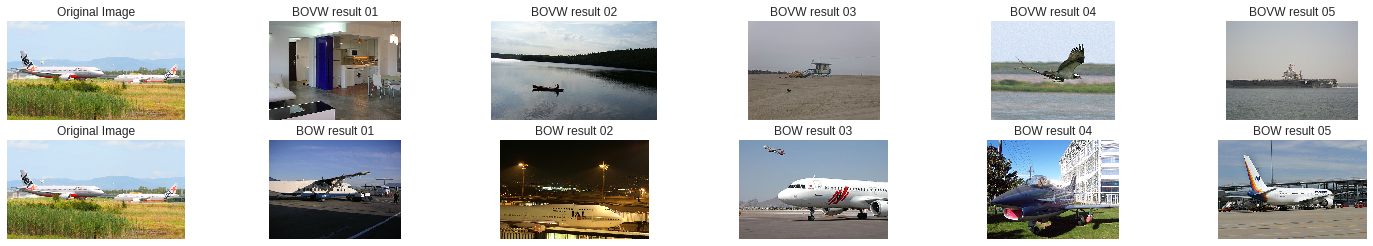

In [36]:
#find similar images for the 0th index image in the array
find_similar_images = 0

#call the kmeans method
kmeans_r1, kmeans_r2, kmeans_r3, kmeans_r4, kmeans_r5 = compute_kmeans(find_similar_images)

#call the cosine method
cosine_r1, cosine_r2, cosine_r3, cosine_r4, cosine_r5, = compute_cosines(find_similar_images)


#plot the results
plt.figure(figsize=(25, 4))


plt.subplot(2, 6, 1)
plt.title('Original Image')
plt.imshow(images_array_list[find_similar_images])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 2)
plt.title('BOVW result 01')
plt.imshow(images_array_list[kmeans_r1])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 3)
plt.title('BOVW result 02')
plt.imshow(images_array_list[kmeans_r2])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 4)
plt.title('BOVW result 03')
plt.imshow(images_array_list[kmeans_r3])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 5)
plt.title('BOVW result 04')
plt.imshow(images_array_list[kmeans_r4])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 6)
plt.title('BOVW result 05')
plt.imshow(images_array_list[kmeans_r5])
plt.xticks([]), plt.yticks([])


plt.subplot(2, 6, 7)
plt.title('Original Image')
plt.imshow(images_array_list[find_similar_images])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 8)
plt.title('BOW result 01')
plt.imshow(images_array_list[cosine_r1])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 9)
plt.title('BOW result 02')
plt.imshow(images_array_list[cosine_r2])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 10)
plt.title('BOW result 03')
plt.imshow(images_array_list[cosine_r3])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 11)
plt.title('BOW result 04')
plt.imshow(images_array_list[cosine_r4])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 12)
plt.title('BOW result 05')
plt.imshow(images_array_list[cosine_r5])
plt.xticks([]), plt.yticks([])
plt.show()

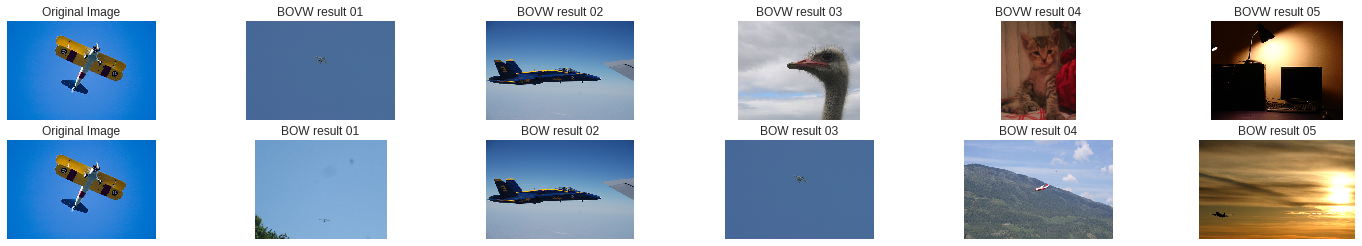

In [37]:
#find similar images for the 20th index image in the array
find_similar_images = 20

#call the kmeans method
kmeans_r1, kmeans_r2, kmeans_r3, kmeans_r4, kmeans_r5 = compute_kmeans(find_similar_images)

#call the cosine method
cosine_r1, cosine_r2, cosine_r3, cosine_r4, cosine_r5, = compute_cosines(find_similar_images)


#plot the results
plt.figure(figsize=(25, 4))


plt.subplot(2, 6, 1)
plt.title('Original Image')
plt.imshow(images_array_list[find_similar_images])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 2)
plt.title('BOVW result 01')
plt.imshow(images_array_list[kmeans_r1])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 3)
plt.title('BOVW result 02')
plt.imshow(images_array_list[kmeans_r2])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 4)
plt.title('BOVW result 03')
plt.imshow(images_array_list[kmeans_r3])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 5)
plt.title('BOVW result 04')
plt.imshow(images_array_list[kmeans_r4])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 6)
plt.title('BOVW result 05')
plt.imshow(images_array_list[kmeans_r5])
plt.xticks([]), plt.yticks([])


plt.subplot(2, 6, 7)
plt.title('Original Image')
plt.imshow(images_array_list[find_similar_images])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 8)
plt.title('BOW result 01')
plt.imshow(images_array_list[cosine_r1])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 9)
plt.title('BOW result 02')
plt.imshow(images_array_list[cosine_r2])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 10)
plt.title('BOW result 03')
plt.imshow(images_array_list[cosine_r3])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 11)
plt.title('BOW result 04')
plt.imshow(images_array_list[cosine_r4])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 12)
plt.title('BOW result 05')
plt.imshow(images_array_list[cosine_r5])
plt.xticks([]), plt.yticks([])
plt.show()

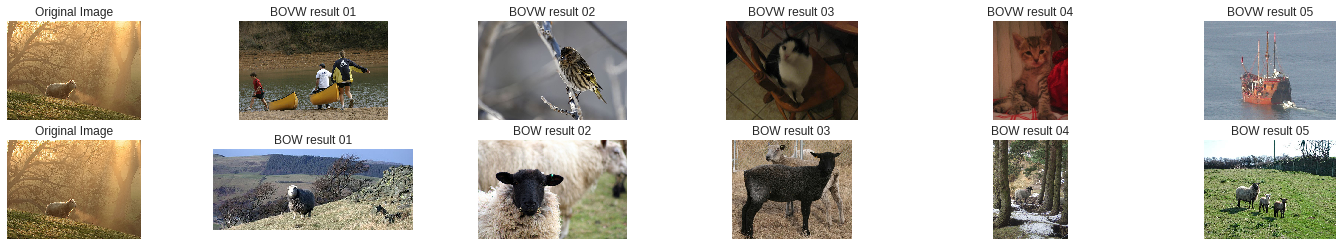

In [38]:
#find similar images for the 800th index image in the array
find_similar_images = 800

#call the kmeans method
kmeans_r1, kmeans_r2, kmeans_r3, kmeans_r4, kmeans_r5 = compute_kmeans(find_similar_images)

#call the cosine method
cosine_r1, cosine_r2, cosine_r3, cosine_r4, cosine_r5, = compute_cosines(find_similar_images)


#plot the results
plt.figure(figsize=(25, 4))


plt.subplot(2, 6, 1)
plt.title('Original Image')
plt.imshow(images_array_list[find_similar_images])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 2)
plt.title('BOVW result 01')
plt.imshow(images_array_list[kmeans_r1])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 3)
plt.title('BOVW result 02')
plt.imshow(images_array_list[kmeans_r2])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 4)
plt.title('BOVW result 03')
plt.imshow(images_array_list[kmeans_r3])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 5)
plt.title('BOVW result 04')
plt.imshow(images_array_list[kmeans_r4])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 6)
plt.title('BOVW result 05')
plt.imshow(images_array_list[kmeans_r5])
plt.xticks([]), plt.yticks([])


plt.subplot(2, 6, 7)
plt.title('Original Image')
plt.imshow(images_array_list[find_similar_images])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 8)
plt.title('BOW result 01')
plt.imshow(images_array_list[cosine_r1])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 9)
plt.title('BOW result 02')
plt.imshow(images_array_list[cosine_r2])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 10)
plt.title('BOW result 03')
plt.imshow(images_array_list[cosine_r3])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 11)
plt.title('BOW result 04')
plt.imshow(images_array_list[cosine_r4])
plt.xticks([]), plt.yticks([])

plt.subplot(2, 6, 12)
plt.title('BOW result 05')
plt.imshow(images_array_list[cosine_r5])
plt.xticks([]), plt.yticks([])
plt.show()

**Compare**

According to the results its clear that BOW is more accurate than BOVW.

BOVW's accuracy is mainly based on keypoints extracted from the images, so it is clear that some of the keypoints extracted are not that useful or accurate.

BOW's accuracy is mainly based on keywords and cosine similarity between documents, which leads to a better accuracy results. However there is a catch in this method as we do not consider ngrams. What is there is a document like "this is not a sheep, there is no sheep in this picture", soaccording to the description our method will return five similar pictures with description similar to sheeps, which is incorrect.